In [ ]:
%load_ext autoreload
%autoreload 2

In [550]:
import tg
import tg.obj as obj
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np

In [551]:
with open('data/susan.obj') as f:
    lines = f.readlines()

triangles, normals = obj.load(lines)

triangles = tf.constant(triangles, dtype=tf.float32)
normals = tf.constant(normals, dtype=tf.float32)
colors = tf.random.uniform(triangles.shape, dtype=tf.float32)

triangles = -triangles
normals = -normals

triangles += (0, 0, 5)


In [552]:
dtype = tf.float64

In [553]:
near_limit = 1
far_limit = 10
focal_length = 1000
width = 1000
height = 500

In [554]:
def perspective(triangles):
    scale = focal_length / triangles[...,2]
    x = triangles[...,0] * scale
    y = triangles[...,1] * scale
    z = triangles[...,2]
    return tf.stack([x + width/2, y + height/2, z], axis=-1)

def vertex_shader(triangles, colors, normals):
    colors = (normals + 1) / 2
    return triangles, colors

def pixel_shader(coordinates, colors):
    return colors

In [557]:
with tf.device("/CPU:0"):
    color = tg.render(triangles, (colors, normals), width, height, near_limit, far_limit, perspective, vertex_shader, pixel_shader, dtype)

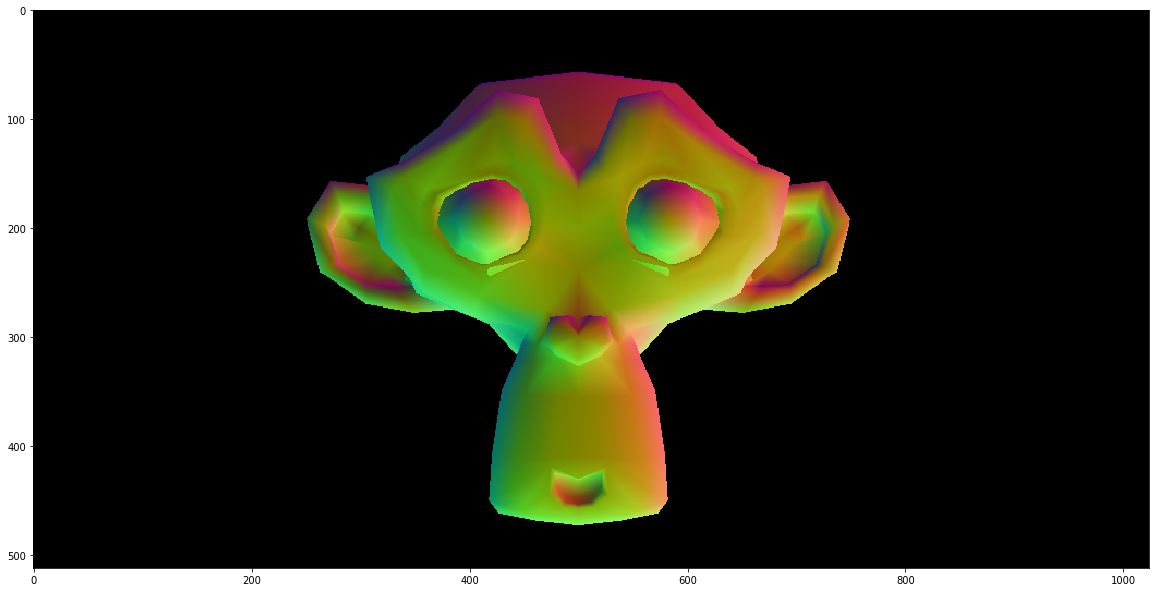

In [558]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(
    # tf.transpose(depth),
    tf.transpose(tf.cast(color, tf.float32), (1, 0, 2)),
    interpolation='nearest'
)
pass